In [1]:
import os
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
import numpy as np
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt

In [14]:
drive = 'D:'
big_ortho_dir = drive+'/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog'
big_ortho_fname = '/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif'

big_dem_dir = drive+'/crs/proj/2021_FloSupp_Release/Clipped_Final/'
big_dem_fname = '/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif'

work_dir = drive+'/crs/proj/2022_NOPP/Composite_Experiment'
gm_dir = '/gm'
dem_dir = '/dem'
slope_dir = '/slope'
ortho_dir = '/ortho'
grayscale_dir = '/grayscale'
   
#gdal_calc.py -R input.tif --R_band=1 -G input.tif --G_band=2 -B input.tif --B_band=3 --outfile=result.tif --calc="R*0.2989+G*0.5870+B*0.1140"

Basename:  20180830_s0


In [3]:
# Make sure working folder exists
try:
    os.makedirs(work_dir)
except FileExistsError:
    # directory already exists
    print(work_dir,' exists.')

### Establish bounding box for the site

In [13]:
# define a box
ulx=392750.
uly=3873000.
boxx = 3800.
boxy = 2500.

urx=ulx+boxx
lrx=ulx+boxx
llx=ulx

ury=uly
lry=uly-boxy
lly=uly-boxy

# make sure GlobalMapper folder exists
out_dir = work_dir+gm_dir
try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

# write corners of the box into a .csv file
corners_file = 'bbox_corners.csv'
f = open(out_dir+corners_file, 'w')
f.write('{:.1f},{:.1f}\n'.format(ulx,ury))
f.write('{:.1f},{:.1f}\n'.format(urx,ury))
f.write('{:.1f},{:.1f}\n'.format(lrx,lry))
f.write('{:.1f},{:.1f}\n'.format(llx,lly))
f.write('{:.1f},{:.1f}\n'.format(ulx,ury))
f.close()
print('Wrote', out_dir+corners_file)

D:/crs/proj/2022_NOPP/Composite_Experiment/gm  exists.
Wrote D:/crs/proj/2022_NOPP/Composite_Experiment/gm/bbox_corners.csv


### Cut out the ortho for that site
Keep as a geotiff for now.

In [29]:
infile = big_ortho_dir+big_ortho_fname
out_dir = work_dir+ortho_dir
ortho_file = '/ortho.tif'
out_file = out_dir+ortho_file

try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -b 2 -b 3 -of GTiff {} {}'.format(ulx, uly, lrx, lry, infile, out_file)
print(gdal_cmd)
if os.system(gdal_cmd) == 0:
    print('Success')
    os.system('gdalinfo {}'.format(out_file))

D:/crs/proj/2022_NOPP/Composite_Experiment/ortho exists.
gdal_translate -projwin 392750.0 3873000.0 396550.0 3870500.0 -b 1 -b 2 -b 3 -of GTiff D:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif D:/crs/proj/2022_NOPP/Composite_Experiment/ortho/ortho.tif
Success


### Read in the ortho for other calcs

In [43]:
in_file = work_dir+ortho_dir+ortho_file
ds_ortho = rio.open_rasterio(in_file)
ds_ortho

<xarray.DataArray (band: 3, y: 10000, x: 15200)>
[456000000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 3.928e+05 3.928e+05 ... 3.965e+05 3.965e+05
  * y            (y) float64 3.873e+06 3.873e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [44]:
# pull bands out as arrays
r = np.array(ds_ortho[0].values)
g = np.array(ds_ortho[1].values)
b = np.array(ds_ortho[2].values)

### Make a grayscale ortho

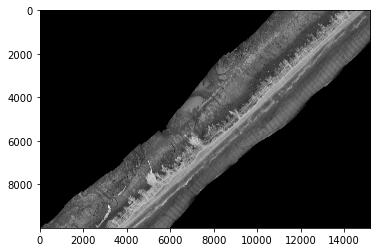

In [45]:
gray = (0.2989*r + 0.5870*g + 0.1140*b).astype('uint8')
plt.imshow(gray, cmap='gray')

In [26]:
infile = work_dir+ortho_dir+'/ortho.tif'
out_dir = work_dir+grayscale_dir
outfile = out_dir+'/gray_ortho.tif'

try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')
    
print('infile: ',infile,'\noutfile', outfile)

D:/crs/proj/2022_NOPP/Composite_Experiment/grayscale  exists.
Infile:  D:/crs/proj/2022_NOPP/Composite_Experiment/ortho/ortho.tif 
Outfile D:/crs/proj/2022_NOPP/Composite_Experiment/grayscale/gray_ortho.tif
